In [1]:
import timeit
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
import napari_segment_blobs_and_things_with_membranes as nsbatwm

In [3]:
import pyclesperanto_prototype as prototype

prototype.set_wait_for_kernel_finish(True)
prototype.select_device("RTX")

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [4]:
from pyclesperanto import cle

cle.set_wait_for_kernel_to_finish(True)

cle.select_device("RTX")

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [5]:
warmup_iter = 3
eval_iter = 5

In [6]:
original_image = imread("https://github.com/clEsperanto/clesperanto_example_data/raw/main/Lund_000500_resampled-cropped.tif")

original_image.shape

(100, 256, 256)

In [7]:
np.prod(original_image.shape) * 2 / 1024 / 1024

12.5

In [8]:
sizes = [1,2,4,6,8,10,12]

In [9]:
def benchmark_function(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    benchmark_data = []
    for size in sizes:
        # make new data
        image = np.concatenate(tuple([original_image] * size))
        print(image.shape)
        
        image_size = np.prod(image.shape) * 4 # assuming the image is internally handled in type float
        
        # bind target function to given image
        partial_function = partial(target_function, image)
        # warmup       
        warm_up_time_in_s = timeit.timeit(partial_function, number=warmup_iter)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=eval_iter)
        # store results
        benchmark_data.append([image_size, time_in_s])
    return np.asarray(benchmark_data)

In [10]:
def prototype_function(image):
    background_subtracted = prototype.top_hat_box(image, radius_x=5, radius_y=5, radius_z=5)
    return prototype.voronoi_otsu_labeling(background_subtracted, spot_sigma=2, outline_sigma=2)
    
prototype_benchmark_data = benchmark_function(prototype_function)
prototype_benchmark_data

(100, 256, 256)
(200, 256, 256)
(400, 256, 256)
(600, 256, 256)
(800, 256, 256)
(1000, 256, 256)
(1200, 256, 256)


array([[2.62144000e+07, 1.20079610e+00],
       [5.24288000e+07, 1.86789750e+00],
       [1.04857600e+08, 3.63066110e+00],
       [1.57286400e+08, 4.71173200e+00],
       [2.09715200e+08, 6.77858060e+00],
       [2.62144000e+08, 7.69325420e+00],
       [3.14572800e+08, 1.00485643e+01]])

In [11]:
def cle_function(image):
    background_subtracted = cle.top_hat_box(image, radius_x=5, radius_y=5, radius_z=5)
    return cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=2, outline_sigma=2)
    
cle_benchmark_data = benchmark_function(cle_function)
cle_benchmark_data

(100, 256, 256)
(200, 256, 256)
(400, 256, 256)
(600, 256, 256)
(800, 256, 256)
(1000, 256, 256)
(1200, 256, 256)


array([[2.6214400e+07, 1.8231291e+00],
       [5.2428800e+07, 2.1149646e+00],
       [1.0485760e+08, 3.6648962e+00],
       [1.5728640e+08, 5.3638009e+00],
       [2.0971520e+08, 6.5195776e+00],
       [2.6214400e+08, 7.9710283e+00],
       [3.1457280e+08, 8.8111014e+00]])

In [12]:
def nsbatwm_function(image):
    background_subtracted = nsbatwm.white_tophat(image, radius=5)
    return nsbatwm.voronoi_otsu_labeling(background_subtracted, spot_sigma=2, outline_sigma=2)

nsbatwm_benchmark_data = benchmark_function(nsbatwm_function)
nsbatwm_benchmark_data

(100, 256, 256)
(200, 256, 256)
(400, 256, 256)
(600, 256, 256)
(800, 256, 256)
(1000, 256, 256)
(1200, 256, 256)


array([[2.62144000e+07, 7.03326810e+00],
       [5.24288000e+07, 1.44142770e+01],
       [1.04857600e+08, 2.98342197e+01],
       [1.57286400e+08, 4.51662187e+01],
       [2.09715200e+08, 6.10155255e+01],
       [2.62144000e+08, 7.71412396e+01],
       [3.14572800e+08, 9.40504974e+01]])

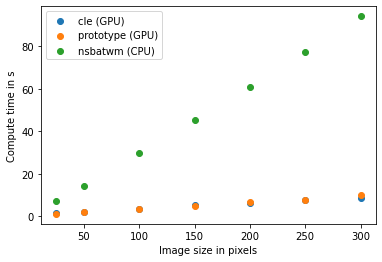

In [13]:
plt.scatter(cle_benchmark_data[:,0] / 1024 / 1024, cle_benchmark_data[:,1])
plt.scatter(prototype_benchmark_data[:,0] / 1024 / 1024, prototype_benchmark_data[:,1])
plt.scatter(nsbatwm_benchmark_data[:,0] / 1024 / 1024, nsbatwm_benchmark_data[:,1])

plt.legend(["cle (GPU)", "prototype (GPU)", "nsbatwm (CPU)"])
plt.xlabel("Image size in pixels")
plt.ylabel("Compute time in s")
plt.show()

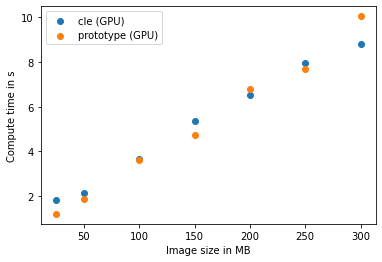

In [14]:
plt.scatter(cle_benchmark_data[:,0] / 1024 / 1024, cle_benchmark_data[:,1])
plt.scatter(prototype_benchmark_data[:,0] / 1024 / 1024, prototype_benchmark_data[:,1])

plt.legend(["cle (GPU)", "prototype (GPU)"])
plt.xlabel("Image size in MB")
plt.ylabel("Compute time in s")
plt.show()

Just checking if all three produce _similar / reasonable_ results. I'm not expecting equal label images.

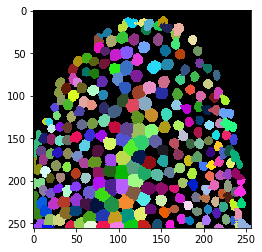

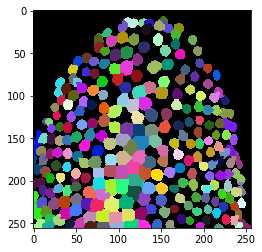

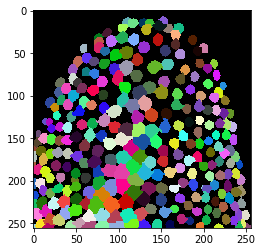

In [15]:
cle.imshow(prototype.pull(prototype_function(original_image)), labels=True)
cle.imshow(cle_function(original_image), labels=True)
cle.imshow(nsbatwm_function(original_image), labels=True)